# BBLF AI Selector: Part 1: Pre Tournament Optimal Squad - Model Pipeline

# Prerequistes

In [3]:
# 0. Prerequistes

import pandas as pd
import numpy as np
import math
import os
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import (DecisionTreeRegressor, plot_tree, export_text)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,root_mean_squared_error, mean_absolute_percentage_error, r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
import sklearn.model_selection as skm
import joblib

  # Interpret
import interpret
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor

os.getcwd()
directory = 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI'

# Data Extraction

In [4]:
# 1. Data Extraction 
    # Pull in model_data csv file 

model_df = pd.read_csv(os.path.join(directory,'data/python_datasets/bblf_p1_FS.csv'), low_memory=False)
print(model_df)

#model_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = model_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(bool)
model_df["Home_f"] = model_df["Home_f"].astype(str)
model_df["Home_f"] = model_df["Home_f"].astype(object)
model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"] = model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"].astype(object)


print(model_df.dtypes)
model_df_NA_rm = model_df.dropna()

       Unnamed: 0   match_id        player  season  resp_var             team  \
0               0  1023649.0       AC Agar       6      13.0  Perth Scorchers   
1               1  1023649.0     AJ Turner       6      23.0  Perth Scorchers   
2               2  1023649.0        AJ Tye       6      22.0  Perth Scorchers   
3               3  1023649.0  BJ Dwarshuis       6      32.0    Sydney Sixers   
4               4  1023649.0     BJ Haddin       6      58.0    Sydney Sixers   
...           ...        ...           ...     ...       ...              ...   
10313       12172  1386137.0     SA Abbott      13     139.0    Sydney Sixers   
10314       12173  1386137.0    SH Johnson      13     111.0    Brisbane Heat   
10315       12174  1386137.0   SNJ O'Keefe      13      41.0    Sydney Sixers   
10316       12175  1386137.0      T Murphy      13      11.0    Sydney Sixers   
10317       12176  1386137.0   XC Bartlett      13      45.0    Brisbane Heat   

       season_fp_lag1  avg_

C:\Users\dilan\AppData\Local\Temp\ipykernel_31772\3456230500.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"] = model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"].astype(object)
C:\Users\dilan\AppData\Local\Temp\ipykernel_31772\3456230500.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"] = model_df.loc[:,"opp_Adelaide Strikers":"rank_group_Middle"].astype(object)
C:\Users\dilan\AppData\Local\Temp\ipykernel_31772\3456230500.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and

# Feature Selection

In [5]:
# 2. Feature Selection
    # Dropping Columns & Create Split Data prior to modelling
col_names = model_df.columns
print (col_names)

other_var_drop = ["resp_var", "Unnamed: 0","season", "player", "team", "match_id"]
feat_drop = ['match_cnt_lag1', 'season_fp_lag2', 'avg_season_fp_lag2','max_season_fp_lag2', 'min_season_fp_lag2', 'med_season_fp_lag2','sd_season_fp_lag2', 'match_cnt_lag2', 'season_fp_lag3','avg_season_fp_lag3', 'max_season_fp_lag3', 'min_season_fp_lag3','med_season_fp_lag3', 'sd_season_fp_lag3', 'match_cnt_lag3',
             'venue_Adelaide Oval', 'venue_GABBA','venue_Hobart', 'venue_Marvel', 'venue_Melbourne Cricket Ground','venue_Other', 'venue_Perth Stadium', 'venue_SCG','venue_Sydney Showground']
# feat_drop = ['match_cnt_lag2','match_cnt_lag3']


print(feat_drop)

X = model_df.drop(other_var_drop, axis = 1)
X = X.drop(feat_drop, axis = 1)
Y = model_df["resp_var"]

print(X)
print(Y)

print(X.dtypes)

X_na_rm = model_df_NA_rm.drop(other_var_drop, axis = 1)
X_na_rm = X_na_rm.drop(feat_drop, axis = 1)
Y_na_rm = model_df_NA_rm["resp_var"]


Index(['Unnamed: 0', 'match_id', 'player', 'season', 'resp_var', 'team',
       'season_fp_lag1', 'avg_season_fp_lag1', 'max_season_fp_lag1',
       'min_season_fp_lag1', 'med_season_fp_lag1', 'sd_season_fp_lag1',
       'match_cnt_lag1', 'season_fp_lag2', 'avg_season_fp_lag2',
       'max_season_fp_lag2', 'min_season_fp_lag2', 'med_season_fp_lag2',
       'sd_season_fp_lag2', 'match_cnt_lag2', 'season_fp_lag3',
       'avg_season_fp_lag3', 'max_season_fp_lag3', 'min_season_fp_lag3',
       'med_season_fp_lag3', 'sd_season_fp_lag3', 'match_cnt_lag3', 'Home_f',
       'rank', 'opp_Adelaide Strikers', 'opp_Brisbane Heat',
       'opp_Hobart Hurricanes', 'opp_Melbourne Renegades',
       'opp_Melbourne Stars', 'opp_Perth Scorchers', 'opp_Sydney Sixers',
       'opp_Sydney Thunder', 'venue_Adelaide Oval', 'venue_GABBA',
       'venue_Hobart', 'venue_Marvel', 'venue_Melbourne Cricket Ground',
       'venue_Other', 'venue_Perth Stadium', 'venue_SCG',
       'venue_Sydney Showground', 'rank_g

# Train/ Test Split

In [6]:
# 3. Train/ Test Split

seed = 42
np.random.seed(seed)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

names = list(X_train)

X_train_na_rm, X_test_na_rm, Y_train_na_rm, Y_test_na_rm = train_test_split(X_na_rm, Y_na_rm, test_size=0.20, random_state=seed)


# EDA

In [7]:
# EDA 
marginal = Marginal(names).explain_data(X_train_na_rm, Y_train_na_rm, name='Train Data')
show(marginal)



<!-- http://127.0.0.1:7001/2773207169312/ -->

# Model Builder

In [8]:
# 4. Model Build
# 4.0. Model Type Options: a. Linear Regression; b. Decision Tree; c. Random Forest, d. Bagging e. EBM f. GBM

Model_Type = "Random Forest"
print(Model_Type)

Random Forest


In [9]:

# 4a. Linear Regression
if Model_Type == "Linear Regression":
    # Model Object
    model_obj = LinearRegression(fit_intercept = True).fit(X_train, Y_train)
    print("Model Coefficients:", model_obj.coef_)
    print("Model Intercept:", model_obj.coef_)
    X_train_OLS = sm.add_constant(X_train)
    OLS(Y_train,X_train_OLS).fit().summary()

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)
    
else:
  print("Note: To create Linear Regression Model change Model Type")

    
# 4b. Decision Tree
if Model_Type == "Decision Tree":
    # Model Object
    model_obj = tree.DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

    # Tree Rules
    rules = tree.export_text(model_obj, feature_names = names)
    print(rules)

    tree.plot_tree(model_obj, feature_names = names, filled = True)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

else:
  print("Note: To create Decision Tree Model change Model Type")

# 4c. Random Forest
if Model_Type == "Random Forest":
    # Model Object     
    model_obj = RandomForestRegressor(max_features = round(math.sqrt(len(X_train.columns))), n_estimators=5000, random_state=0, oob_score=True).fit(X_train, Y_train)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)
    
    # Feature List
    print(X_train.columns)
    max_feat = round(math.sqrt(len(X_train.columns)))
    print(max_feat)   

    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)
    
else:
  print("Note: To create Random Forest Model change Model Type")

# 4d. Bagging
if Model_Type == "Bagging":
    # Model Object
    model_obj = RandomForestRegressor(max_features=X_train.shape[1], n_estimators=5000, random_state=0).fit(X_train, Y_train)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)
    
    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)

else:
  print("Note: To create Bagging Model change Model Type")

# 4e. EBM
if Model_Type == "EBM":
    # Model Object
    model_obj = ExplainableBoostingRegressor(names, interactions=0).fit(X_train, Y_train)

    # Global Performance
    ebm_global = model_obj.explain_global(name='EBM')
    show(ebm_global)

    # Local Performance
    ebm_local = model_obj.explain_local(X_test, Y_test, name='EBM')
    show(ebm_local, 0)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

else:
  print("Note: To create EBM change Model Type")

# 4f. Boosting
if Model_Type == "GBM":
    # Model Object
    model_obj = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.001, max_depth = 2, random_state=0).fit(X_train_na_rm, Y_train_na_rm)

    # Train Pred
    Y_pred_train = model_obj.predict(X_train_na_rm)
    print(Y_pred_train)

    # Test Pred
    Y_pred_test = model_obj.predict(X_test_na_rm) 
    print(Y_pred_test)

    # Model Type 
    print(Model_Type)

    # Feature List
    print(X_train.columns)

    # feature importance
    feature_imp = pd.DataFrame(
    {'importance':model_obj.feature_importances_},
    index=names)
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    print(feature_imp)

else:
  print("Note: To create GBM change Model Type")

Note: To create Linear Regression Model change Model Type
Note: To create Decision Tree Model change Model Type
[33.99746629 58.06898142 79.29190392 ... 53.20398482 35.20010957
 29.84330037]
[59.46901393 35.59492499 34.28009851 ... 23.13542945 66.78943198
 38.74046966]
Random Forest
Index(['season_fp_lag1', 'avg_season_fp_lag1', 'max_season_fp_lag1',
       'min_season_fp_lag1', 'med_season_fp_lag1', 'sd_season_fp_lag1',
       'Home_f', 'rank', 'opp_Adelaide Strikers', 'opp_Brisbane Heat',
       'opp_Hobart Hurricanes', 'opp_Melbourne Renegades',
       'opp_Melbourne Stars', 'opp_Perth Scorchers', 'opp_Sydney Sixers',
       'opp_Sydney Thunder', 'rank_group_High', 'rank_group_Low',
       'rank_group_Middle', 'Home_Adelaide Strikers', 'Home_Melbourne Stars',
       'Home_Melbourne Renegades', 'Home_Brisbane Heat',
       'Home_Perth Scorchers', 'Home_Sydney Sixers', 'Home_Sydney Thunder',
       'Home_Hobart Hurricanes'],
      dtype='object')
5
                          importance

MAE - Train: 14.522162465419072
MAPE - Train: 56.90090925282675
RMSE - Train: 20.082095260308208
R2 - Train: 0.6460633083843186


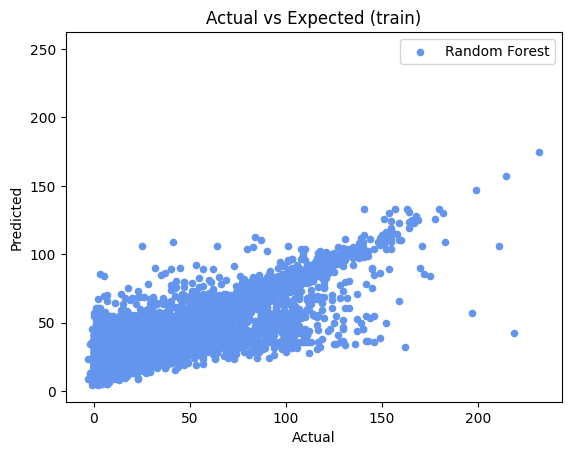

MAE - Test: 28.405376018034655
MAPE - Test: 173.41998367800701
RMSE - Test: 35.67458965372675
R2 - Test: -0.10254090251889081


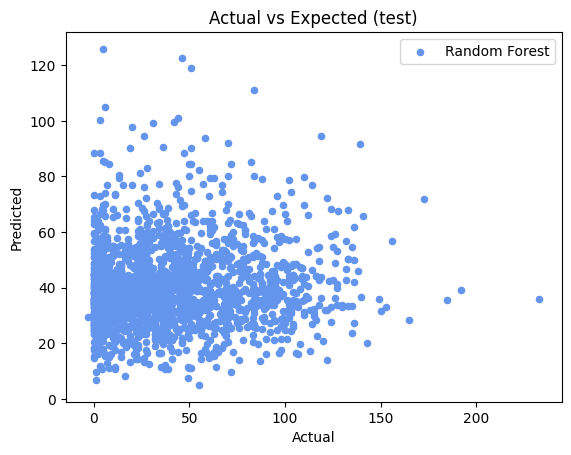

In [10]:
# 5. Model Performance

# 5a. Train Performance Metrics
 
mae_train = mean_absolute_error(y_true = Y_train, y_pred = Y_pred_train)
mape_train = mean_absolute_percentage_error(y_true = Y_train, y_pred = Y_pred_train) 
rmse_train = root_mean_squared_error(y_true = Y_train, y_pred = Y_pred_train) 
r2_train = r2_score(y_true = Y_train, y_pred = Y_pred_train)

print("MAE - Train:", mae_train) 
print("MAPE - Train:", mape_train) 
print("RMSE - Train:", rmse_train)
print("R2 - Train:", r2_train)

  # Actual vs Expected Plots

plt.figure()
plt.scatter(Y_train, Y_pred_train, s = 20, color="cornflowerblue", label=Model_Type)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Expected (train)")
plt.plot([0, 0], [250, 250], 'k-')
plt.legend()
plt.show()

# 5b. Test Performance Metrics

mae_test = mean_absolute_error(y_true = Y_test, y_pred = Y_pred_test) 
mape_test = mean_absolute_percentage_error(y_true = Y_test, y_pred = Y_pred_test) 
rmse_test = root_mean_squared_error(y_true = Y_test, y_pred = Y_pred_test) 
r2_test = r2_score(y_true = Y_test, y_pred = Y_pred_test)

print("MAE - Test:", mae_test)
print("MAPE - Test:", mape_test)
print("RMSE - Test:", rmse_test)
print("R2 - Test:", r2_test)

  # Actual vs Expected Plots

plt.figure()
plt.scatter(Y_test, Y_pred_test, s = 20, color="cornflowerblue", label= Model_Type)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Expected (test)")
plt.legend()
plt.show()

# Model Scoring for Current Players

In [ ]:
# Save model object
# joblib.dump(model_obj, 'C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/model/pre_tourny_model')
# model_obj = joblib.load('C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/model/pre_tourny_model')


RandomForestRegressor(max_features=5, n_estimators=5000, oob_score=True,
                      random_state=0)


In [179]:
# 6. Use Model Object to calculate the number of points for each current player for each gameweek
    # 6a. Data Extraction of BBL 14 Data

# BBL 14 Player & their Team Data

player_df = pd.read_csv(os.path.join(directory,'data/python_datasets/player_price.csv'), low_memory=False)
player_df = player_df[["Full_Name","player", "Team"]].rename(columns = {"Full_Name":"Name"})
print(player_df)

# BBL 14 Player Features
    # Lags
lags_14_df = pd.read_csv(os.path.join(directory,'data/python_datasets/bbl14_lags.csv'), low_memory=False)
lags_14_df = lags_14_df.drop(["Unnamed: 0"], axis = 1)
print(lags_14_df)

# BBL14 Fixture
    ## Need a table of for each team which opposition and where they play against the opposition

team_venue_df = pd.read_csv(os.path.join(directory,'data/python_datasets/team_loc_fixture.csv'), low_memory=False)
print(team_venue_df)

## Join BBL14 Player Team Data - All Player Fixture Possible Scenarios
player_fix_scen_df = pd.merge(player_df , team_venue_df, left_on = ["Team"], right_on = ["Team"], how = "left")
player_fix_scen_df = player_fix_scen_df.rename(columns = {"Opposition":"opp", "Venue":"venue"})
print(player_fix_scen_df)

## Join BBL14 Player Feature Data - All Player Fixture Possible Scenarios
bbl14_scen_df = pd.merge(player_fix_scen_df , lags_14_df, left_on = ["player"], right_on = ["player"], how = "left")
print(bbl14_scen_df)

unique_play_fix = player_fix_scen_df['player'].unique()
print(unique_play_fix)

unique_lag = lags_14_df['player'].unique()
print(unique_lag)

# BBL14 Rank Data
team_rank_14_df = pd.read_csv(os.path.join(directory,'data/python_datasets/team_season_rank.csv'), low_memory=False)
team_rank_14_df = team_rank_14_df[team_rank_14_df["season"] == 14].rename(columns = {"team":"Team"})
print(team_rank_14_df)

bbl14_scen_df = pd.merge(bbl14_scen_df , team_rank_14_df, left_on = ["Team"], right_on = ["Team"], how = "left")

# One Hot Encoding
bbl14_play_scen_df = pd.get_dummies(bbl14_scen_df, columns= ['opp','venue','rank_group'])

bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"] = bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"].astype(int)
bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"] = bbl14_play_scen_df.loc[:,"opp_Adelaide Strikers":"opp_Sydney Thunder"].astype(object)

bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(int)
bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"] = bbl14_play_scen_df.loc[:,"venue_Adelaide Oval":"venue_Sydney Showground"].astype(object)

bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"] = bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"].astype(int)
bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"] = bbl14_play_scen_df.loc[:,"rank_group_High":"rank_group_Middle"].astype(object)

# Interaction Terms
# Venue & Home Flag (See if the certain teams have bigger home ground advantage)
bbl14_play_scen_df["Home_Adelaide Strikers"] = np.where((bbl14_play_scen_df["venue_Adelaide Oval"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Melbourne Stars"] = np.where((bbl14_play_scen_df["venue_Melbourne Cricket Ground"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Melbourne Renegades"] = np.where((bbl14_play_scen_df["venue_Marvel"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Brisbane Heat"] = np.where((bbl14_play_scen_df["venue_GABBA"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Perth Scorchers"] = np.where((bbl14_play_scen_df["venue_Perth Stadium"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Sydney Sixers"] = np.where((bbl14_play_scen_df["venue_SCG"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Sydney Thunder"] = np.where((bbl14_play_scen_df["venue_Sydney Showground"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)
bbl14_play_scen_df["Home_Hobart Hurricanes"] = np.where((bbl14_play_scen_df["venue_Hobart"] == 1) & (bbl14_play_scen_df["Home_f"] == 1) , 1 , 0)

bbl14_play_scen_df.loc[:,"Home_Adelaide Strikers":"Home_Hobart Hurricanes"] = bbl14_play_scen_df.loc[:,"Home_Adelaide Strikers":"Home_Hobart Hurricanes"].astype(object)

print(bbl14_play_scen_df)

    # 6b. Score Data
# Drop Columns
bbl14_play_scen_df_model = bbl14_play_scen_df.drop(feat_drop, axis = 1)
bbl14_play_scen_df_model = bbl14_play_scen_df_model.drop(["Name", "player", "Team", "season"], axis = 1)

model_col_ord = X_train.columns
bbl14_play_scen_df_model = bbl14_play_scen_df_model[model_col_ord]

# Player Expected Point Scoring

bbl14_play_score = model_obj.predict(bbl14_play_scen_df_model)
print(bbl14_play_score)

bbl14_scen_model_score = bbl14_scen_df
bbl14_scen_model_score["exp_pts"] = bbl14_play_score
bbl14_scen_model_score = bbl14_scen_model_score.drop(bbl14_scen_model_score.loc[:, 'season':'match_cnt_lag3'].columns, axis = 1)
print(bbl14_scen_model_score)

bbl14_scen_model_score.to_csv('C:/Users/dilan/OneDrive/Documents/Data Science Projects/Big Bash Fantasy AI/data/python_datasets/bbl14_fullteam_model_score.csv')


                Name         player                 Team
0        Sean Abbott      SA Abbott        Sydney Sixers
1        Ashton Agar        AC Agar      Perth Scorchers
2           Wes Agar        WA Agar       Sydney Thunder
3         Finn Allen     Finn Allen      Perth Scorchers
4       Fabian Allen   Fabian Allen    Adelaide Strikers
..               ...            ...                  ...
142        Jon Wells       JW Wells  Melbourne Renegades
143  Jack Wildermuth  JD Wildermuth        Brisbane Heat
144        Jack Wood        JP Wood        Brisbane Heat
145       Mac Wright       M Wright    Hobart Hurricanes
146       Adam Zampa        A Zampa  Melbourne Renegades

[147 rows x 3 columns]
            player        Full_Name  season_fp_lag1  avg_season_fp_lag1  \
0        SA Abbott      Sean Abbott           448.0           49.777778   
1          AC Agar      Ashton Agar           307.0           34.111111   
2          WA Agar         Wes Agar            60.0           15.00

C:\Users\dilan\AppData\Local\Temp\ipykernel_7280\363708885.py:47: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\dilan\AppData\Local\Temp\ipykernel_7280\363708885.py:47: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\dilan\AppData\Local\Temp\ipykernel_7280\363708885.py:47: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 1 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.

C:\Users\dilan\AppData\Local\Temp\ipykernel_7280\363708885.py:47: FutureWarning:

Setting an item of incompatible dtype is depr

[44.37713267 42.85419878 43.30481048 ... 41.02458181 40.59090507
 40.61830898]
             Name     player                 Team                  opp  \
0     Sean Abbott  SA Abbott        Sydney Sixers  Melbourne Renegades   
1     Sean Abbott  SA Abbott        Sydney Sixers       Sydney Thunder   
2     Sean Abbott  SA Abbott        Sydney Sixers      Melbourne Stars   
3     Sean Abbott  SA Abbott        Sydney Sixers        Brisbane Heat   
4     Sean Abbott  SA Abbott        Sydney Sixers    Hobart Hurricanes   
...           ...        ...                  ...                  ...   
1465   Adam Zampa    A Zampa  Melbourne Renegades      Melbourne Stars   
1466   Adam Zampa    A Zampa  Melbourne Renegades      Perth Scorchers   
1467   Adam Zampa    A Zampa  Melbourne Renegades      Melbourne Stars   
1468   Adam Zampa    A Zampa  Melbourne Renegades    Hobart Hurricanes   
1469   Adam Zampa    A Zampa  Melbourne Renegades        Brisbane Heat   

                         venue  